# Polarisation examples

Below are a couple of examples of how to use `WODEN` to simulation polarisation data. Both examples include details on how to generate the FITS-style sky model, how t run the simulation, and check the results. This documentation is simply the notebook found in `WODEN/examples/polarisation/polarisation_examples.ipynb`. If you want to run it, you'll need a working `WODEN` installation, and `WSClean` to do the imaging.

Big shout out to Emil for all the help in getting Jack to (kind of) understanding polarisation, and for the RM synthesis code.

Apologies, I haven't worked out how to get outputs from cells to be scrollable in the online documentation, so please just scroll past the reams of output text to get to plots.

## Southern Hotspot of PKS J0636−2036

This is an example of a real source, details of which can be found in [O'Sullivan et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.475.4263O/abstract). Assuming that the southern lobe is a single point source, at 216MHz, the component has the parameters (from Table 3 of this paper):

Stokes $I = 13.9$ Jy (at reference 216MHz) \
Polarisation fraction $\Pi = 0.092$ \
Spectral index $\alpha = -0.815$ \
Faraday rotation $\phi_\textrm{RM} = 50.2 $ rad $m^{-2}$

Ignoring the jump in frequency and instrument in the measurement (it's an example so we can do what we want) we can also say
Intrinsic rotation angle $\chi_0 = -71.1^{\circ}$

First, we'll make a FITS table with these parameters. Then we'll stick it through `WODEN`, and process the outputs.


In [1]:
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
import numpy as np
from subprocess import call
from astropy.coordinates import EarthLocation
from astropy import units as u
from astropy.time import Time
from astropy.io import fits
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel16
import healpy as hp
from astropy.constants import c
C = c.value

In [2]:


##Stick the source at location of it's name J0636−2036, good enough
coord = SkyCoord(ra='6h36m', dec="-20d36m")
ra0 = coord.ra.deg
dec0 = coord.dec.deg

##These are the parameters for the source
alpha = -0.815
##hyperdrive/WODEN/LoBES catalogues are all referenced to 200MHz, so we need
##to scale the stokesI flux
stokesI = 13.9 * (200/216)**(alpha)
pol_frac = 0.092
phi_RM = 50.2
chi_0 = np.radians(71.1)

##The LoBES/hyperdrive/WODEN catalogues need a unique source ID (UNQ_SOURCE_ID),
##a then edge component of that source needs a name (NAME)
c_ids = Column(data=np.array(['PKS_J0636_source']), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array(['PKS_J0636_source_C00']), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=np.array([ra0]), name='RA')
c_decs = Column(data=np.array([dec0]), name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P'], dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl'], dtype='|S3'), name="MOD_TYPE", dtype='|S3')
##Stokes I power law parameters
c_stokes_I_ref = Column(data=np.array([stokesI]), name='NORM_COMP_PL')
c_stokes_SI = Column(data=np.array([alpha]), name='ALPHA_PL')

##This says we are using a polarisation fraction linear polarisation model
c_lin_mod_type = Column(data=np.array(['pf'], dtype='|S3'), name='LIN_MOD_TYPE', dtype='|S3')
##linear polarisation parameters
c_lin_pol_frac = Column(data=np.array([pol_frac]), name='LIN_POL_FRAC')
c_lin_pol_angle = Column(data=np.array([chi_0]), name='INTR_POL_ANGLE')
c_rm = Column(data=np.array([phi_RM]), name='RM')

##Stick all the columns in a list
columns = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_SI, c_lin_mod_type,c_lin_pol_frac, c_lin_pol_angle, c_rm]

##Make a table
table = Table(columns)

##write the table
cat_name = 'PKS_J0636.fits'
table.write(cat_name, overwrite=True)




Now that we have our single source, let's setup a simple simulation command. For this example, we're just testing the polarisation reponse of `WODEN`, so make a very very basic simulatin. We'll run without a primary beam, put the source at phase centre, and run with just a few baselines via a custom array layout. 

Importantly, we'll set the `--IAU_order` flag, which means that `XX` = north-south, `YY` = east-west. This is the IAU convention for Stokes parameters.

In [3]:

np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 10
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

##stick our array in the MWA location. 
mwa_location = EarthLocation(lat=-26.703319405555554*u.deg, 
                             lon=116.67081523611111*u.deg,
                             height=377.827)

##pick a time/date that sticks our source overhead
date = "2024-07-05T04:00:00"

observing_time = Time(date, scale='utc', location=mwa_location)
##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg}, RA: {ra0}")

##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

uvfits_name = "PKS_J0636"
freq_reso = 80e+3
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam=none '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order'

##use subprocess to run the command
call(command, shell=True)

LST: 100.31812162623258, RA: 98.99999999999999


/home/jack-line/software/anaconda3/envs/woden/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.2.0')


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jack-line/software/WODEN/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 99.00000deg -20.60000deg
Obs epoch initial LST was 100.3222997096 deg
Setting initial J2000 LST to 100.0765133194 deg
Setting initial mjd to 60496.1666782406
After precession initial latitude of the array is -26.6814845743 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
NO PRIMARY BEAM HAS BEEN SELECTED
	Will run without a primary beam
Simulating band 01 with bottom freq 1.80000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk t

0

Righto, now we have an output, let's read it in, convert it to Stokes parameters, and plot the SED.

15


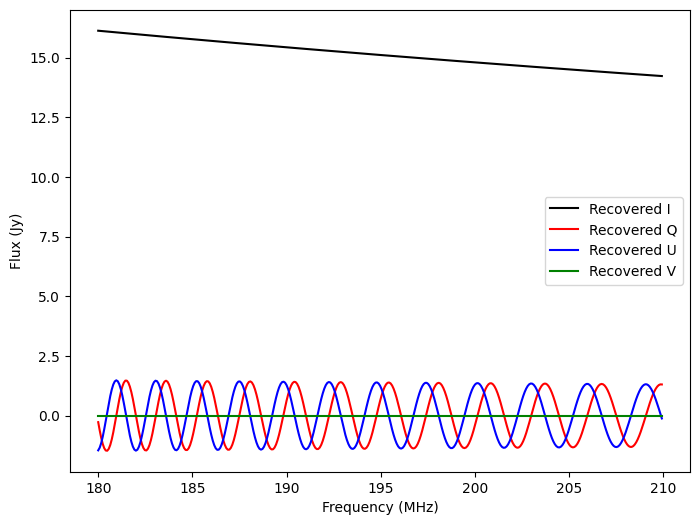

In [4]:

def read_uvfits(uvfits_name):
    """Real shorthand function to read in visibilities from a WODEN UVFITS file"""
    
    with fits.open(uvfits_name) as hdus:
        data = np.squeeze(hdus[0].data.data)
        ##Yup, this is the order of things in a UVFITS file
        XX = data[:, :, 0, 0] + 1j*data[:, :, 0, 1]
        YY = data[:, :, 1, 0] + 1j*data[:, :, 1, 1]
        XY = data[:, :, 2, 0] + 1j*data[:, :, 2, 1]
        YX = data[:, :, 3, 0] + 1j*data[:, :, 3, 1]
        
    return XX, XY, YX, YY
        
XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')

##pick a random baseline to plot, they should all be the same
baseline = np.random.randint(0, XX.shape[0])
print(baseline)

##converts instrumental pols into Stokes params. We didn't use a primary beam
##at we're right at zenith so this is good enough without corrections
recover_I = 0.5*(XX[baseline] + YY[baseline])
recover_Q = 0.5*(XX[baseline] - YY[baseline])
recover_U = 0.5*(XY[baseline] + YX[baseline])
recover_V = -0.5j*(XY[baseline] - YX[baseline])

##these are the freqs we put into the simulation
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()


Lovely, we have some fun wiggly Q/U lines, a power-law Stokes I, and nothing in Stokes V. Let's see if we can recover the RM from this data. All credit to Emil for the RM synthesis code.

Input resolutions going into RM-synthesis:
	Frequency range: 180.000 MHz - 209.920 MHz
	Bandwidth:  29.920 MHz
	Channel width: 80.0 KHz
	dlambda2:   0.002
	Dlambda2:   0.734
	phimax: 702.920
	dphi:   4.717
	phiR:   0.943
	Nphi: 1490.189
Recovered paramaters:
	S = 15.133
	Pol frac from recovered peak = 9.167%
	Mean recovered pol frac: 0.092, Expected: 0.092


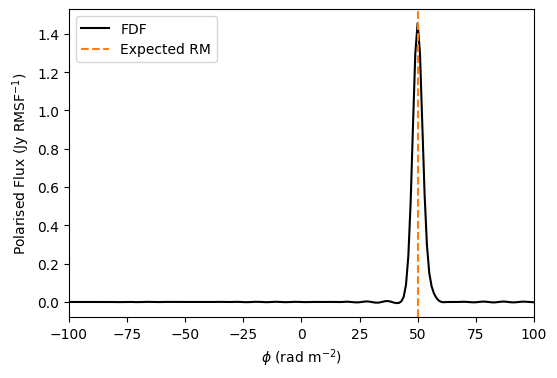

In [5]:

def getFDF(dataQ, dataU, freqs, startPhi, stopPhi, dPhi, dType='float32'):
    """
    # Perform RM-synthesis on Stokes Q and U data
    #
    # dataQ, dataU and freqs - contains the Q/U data at each frequency (in Hz) measured.
    # startPhi, dPhi - the starting RM (rad/m^2) and the step size (rad/m^2)
    
    Author: Emil Lenc
    """

    # Calculate the RM sampling
    phiArr = np.arange(startPhi, stopPhi, dPhi)

    # Calculate the frequency and lambda sampling
    lamSqArr = np.power(C / np.array(freqs), 2.0)

    # Calculate the dimensions of the output RM cube
    nPhi = len(phiArr)

    # Initialise the complex Faraday Dispersion Function (FDF)
    FDF = np.ndarray((nPhi), dtype='complex')

    # Assume uniform weighting
    wtArr = np.ones(len(lamSqArr), dtype=dType)

    K = 1.0 / np.nansum(wtArr)

    # Get the weighted mean of the LambdaSq distribution (B&dB Eqn. 32)
    lam0Sq = K * np.nansum(lamSqArr)

    # Mininize the number of inner-loop operations by calculating the
    # argument of the EXP term in B&dB Eqns. (25) and (36) for the FDF
    a = (-2.0 * 1.0j * phiArr)
    b = (lamSqArr - lam0Sq) 
    arg = np.exp( np.outer(a, b) )

    # Create a weighted complex polarised surface-brightness cube
    # i.e., observed polarised surface brightness, B&dB Eqns. (8) and (14)
    Pobs = (np.array(dataQ) + 1.0j * np.array(dataU))

    # Calculate the Faraday Dispersion Function
    # B&dB Eqns. (25) and (36)
    FDF = K * np.nansum(Pobs * arg, 1)
    return FDF, phiArr

def findpeaks(freqs, fdf, phi, rmsf, rmsfphi, nsigma):
    """Find peaks in the FDF
    Author: Emil Lenc"""
    # Create the Gaussian filter for reconstruction
    lam2 = (C / freqs) ** 2.0
    lam02 = np.mean(lam2)
    minl2 = np.min(lam2)
    maxl2 = np.max(lam2)
    width = (2.0 * np.sqrt(3.0)) / (maxl2 - minl2)

    Gauss = np.exp((-rmsfphi ** 2.0) / (2.0 * ((width / 2.355) ** 2.0)))
    components = np.zeros((len(phi)), np.float32)
    peaks = []
    phis = []
    std = 0.0
    rmsflen = int((len(rmsf) - 1) / 2)
    fdflen = len(phi) + rmsflen
    while True:
        std = np.std(np.abs(fdf))
        peak1 = np.max(np.abs(fdf))
        pos1 = np.argmax(np.abs(fdf))
        val1 = phi[pos1]
        if peak1 < nsigma * std :
            break
        fdf -= rmsf[rmsflen - pos1:fdflen - pos1] * fdf[pos1]
        peaks.append(peak1)
        phis.append(val1)
        components[pos1] += peak1
    fdf += np.convolve(components, Gauss, mode='valid')
    return phis, peaks, std

startPhi = -100.0
dPhi     = 1.0
stopPhi = -startPhi+dPhi
lambda2 = np.power(C / np.array(freqs), 2.0)

df = []
for f in range(1, len(freqs)):
	df.append(freqs[f] - freqs[f-1])
chanBW = np.min(np.array(df))
fmin = np.min(freqs)
fmax = np.max(freqs)
bw = fmax - fmin

dlambda2 = np.power(C / fmin, 2) - np.power(C / (fmin + chanBW), 2)
Dlambda2 = np.power(C / fmin, 2) - np.power(C / (fmin + bw), 2)
phimax = np.sqrt(3) / dlambda2
dphi = 2.0 * np.sqrt(3) / Dlambda2
phiR = dphi / 5.0
Nphi = 2 * phimax / phiR
##These are things that mean something to polarisation peoples
print("Input resolutions going into RM-synthesis:")
print("\tFrequency range: %7.3f MHz - %7.3f MHz" %(fmin / 1.0e6, (fmin + bw) / 1.0e6))
print("\tBandwidth: %7.3f MHz" %(bw / 1.0e6))
print("\tChannel width: %.1f KHz" %(chanBW / 1.0e3))
print("\tdlambda2: %7.3f" %(dlambda2))
print("\tDlambda2: %7.3f" %(Dlambda2))
print("\tphimax: %7.3f" %(phimax))
print("\tdphi: %7.3f" %(dphi))
print("\tphiR: %7.3f" %(phiR))
print("\tNphi: %7.3f" %(Nphi))
fwhm = dphi

# Determine the FDF using the q, u and ferquency values read from the file.
dirty, phi = getFDF(recover_Q, recover_U, freqs, startPhi, stopPhi, dPhi)
FDFqu, phi = getFDF(recover_Q, recover_U, freqs, startPhi, stopPhi, dPhi)
rstartPhi = startPhi * 2
rstopPhi = stopPhi * 2 - dPhi
RMSF, rmsfphi = getFDF(np.ones((len(recover_Q))), np.zeros((len(recover_Q))), freqs, rstartPhi, rstopPhi, dPhi)

phis, peaks, sigma = findpeaks(np.array(freqs), FDFqu, phi, RMSF, rmsfphi, 6.0)
snr = peaks / sigma
phierr = fwhm / (2 * snr)
# print(phis, phierr, peaks, sigma)
imean = np.mean(np.real(recover_I))

print("Recovered paramaters:")

print("\tS = %.3f" %(imean))
if len(peaks) > 0:
	print("\tPol frac from recovered peak = %.3f%%" %(100.0 * peaks[0] / imean))

##What is the polarised flux as a function of frequency
# polarised_flux = np.sqrt(recover_Q**2 + recover_U**2)
polarised_flux = np.abs(recover_Q + 1j*recover_U)

recovered_pol_frac = (polarised_flux.real / recover_I.real)
print(f'\tMean recovered pol frac: {np.mean(recovered_pol_frac):.3f}, Expected: {pol_frac:.3f}')

fig, axs = plt.subplots(1, 1, figsize=(6,4))

axs.plot(phi, np.real(FDFqu), 'k-', label='FDF')

axs.set_xlabel("${\phi}$ (rad m$^{-2}$)")
axs.set_ylabel("Polarised Flux (Jy RMSF$^{-1}$)")

axs.set_xlim(-100, 100)

axs.axvline(x=phi_RM, color='C1', linestyle='--', label='Expected RM')
axs.legend()

plt.show()



Using Emil's magic RM code, we can see a nice strong peak at the expected RM of 50.2 rad/m^2, and we recover the expected polarisation fraction of 9.2%.

## Multiple components same direction

Now let's try sticking a few different components in the same direction, to see if we can disentangle the RMs.

Make a new sky model:

In [6]:

num_comps = 3

##Make some simple component params. Keep everything the same, but vary RM
alpha = np.full(num_comps, -0.815)
stokesI = np.full(num_comps, 1.0)
pol_frac = np.full(num_comps, 0.3)
phi_RM = np.array([10, 50, 90])
chi_0 = np.full(num_comps, 0.0)

##The LoBES/hyperdrive/WODEN catalogues need a unique source ID (UNQ_SOURCE_ID),
##a then edge component of that source needs a name (NAME)
c_ids = Column(data=np.full(num_comps, 'multi_comp',  dtype='|S20'), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=[f'multi_comp_C{comp:02d}' for comp in range(num_comps)], name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=np.full(num_comps, ra0), name='RA')
c_decs = Column(data=np.full(num_comps, dec0), name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.full(num_comps, 'P', dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.full(num_comps, 'pl', dtype='|S3'), name="MOD_TYPE", dtype='|S3')
##Stokes I power law parameters
c_stokes_I_ref = Column(data=stokesI, name='NORM_COMP_PL')
c_stokes_SI = Column(data=alpha, name='ALPHA_PL')

##This says we are using a polarisation fraction linear polarisation model
c_lin_mod_type = Column(data=np.full(num_comps, 'pf', dtype='|S3'), name='LIN_MOD_TYPE', dtype='|S3')
##linear polarisation parameters
c_lin_pol_frac = Column(data=pol_frac, name='LIN_POL_FRAC')
c_lin_pol_angle = Column(data=chi_0, name='INTR_POL_ANGLE')
c_rm = Column(data=phi_RM, name='RM')

##Stick all the columns in a list
columns = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_SI, c_lin_mod_type,c_lin_pol_frac, c_lin_pol_angle, c_rm]

##Make a table
table = Table(columns)

##write the table
cat_name = 'multi_comp.fits'
table.write(cat_name, overwrite=True)

Run it through WODEN, convert outputs into I,Q,U,V, have a look:

/home/jack-line/software/anaconda3/envs/woden/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.2.0')


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jack-line/software/WODEN/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 99.00000deg -20.60000deg
Obs epoch initial LST was 100.3222997096 deg
Setting initial J2000 LST to 100.0765133194 deg
Setting initial mjd to 60496.1666782406
After precession initial latitude of the array is -26.6814845743 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 3 components
After cropping there are 3 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 minsWODEN is using DOUBLE precision

NO PRIMARY BEAM HAS BEEN SELECTED
	Will run without a primary beam
Simulating band 01 with bottom freq 1.80000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk t

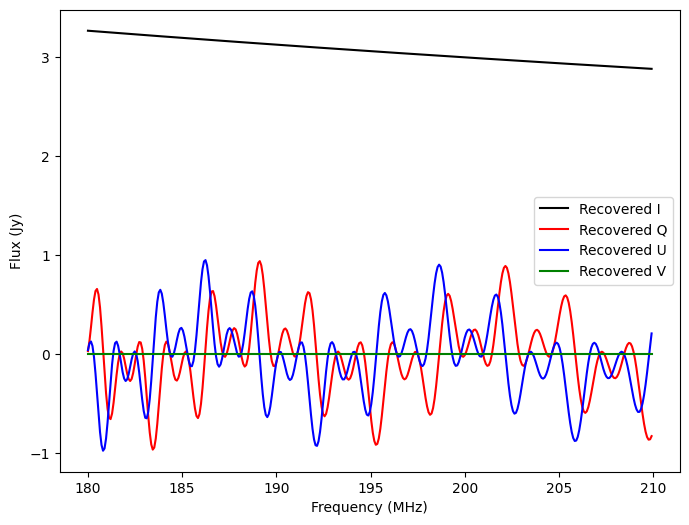

In [7]:
##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam=none '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order'

##use subprocess to run the command
call(command, shell=True)

XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')

##pick a random baseline to plot, they should all be the same
baseline = np.random.randint(0, XX.shape[0])
print(baseline)

##converts instrumental pols into Stokes params. We didn't use a primary beam
##at we're right at zenith so this is good enough without corrections
recover_I = 0.5*(XX[baseline] + YY[baseline])
recover_Q = 0.5*(XX[baseline] - YY[baseline])
recover_U = 0.5*(XY[baseline] + YX[baseline])
recover_V = -0.5j*(XY[baseline] - YX[baseline])

##these are the freqs we put into the simulation
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Wiggly! Alrighty, what do we have in RM space?

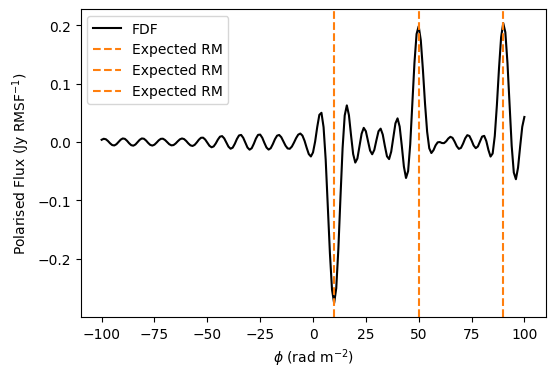

In [8]:
# Determine the FDF using the q, u and ferquency values read from the file.
FDFqu, phi = getFDF(recover_Q, recover_U, freqs, startPhi, stopPhi, dPhi)

fig, axs = plt.subplots(1, 1, figsize=(6,4))

axs.plot(phi, np.real(FDFqu), 'k-', label='FDF')

axs.set_xlabel("${\phi}$ (rad m$^{-2}$)")
axs.set_ylabel("Polarised Flux (Jy RMSF$^{-1}$)")

for phi in phi_RM:
	axs.axvline(x=phi, color='C1', linestyle='--', label='Expected RM')

axs.legend()

plt.show()


I don't know nothing about polarisation, so I don't know if a negative peak in the FDF is bad. But we have three peaks where we expected them to be, which is nice.

## Linear polarisation diffuse sky

In this example, we'll make a crazy made-up sky. Then we'll push it through an instrument which has symmetric X and Y primary beams, which means we can make I/Q/U/V images without beam correction (as there won't be direction dependent differences).

First up, make the sky model. This will be a little involved as we're going to make the Stokes I, linear polarised, and Stokes V sky separately. We'll make Stokes I simple point sources. The linear sky will be the Haslam map (via the [pygdsm](https://github.com/telegraphic/pygdsm) package), and the Stokes V sky will be a bunch of Gaussian blobs. Everything will have a simple power-law SED.

In [9]:

##We're going to use the EDA2 array
##layout, so we can get away with low-resolution sky model. So set the 
##healpixel nside to 256
nside = 256
num_diffuse = hp.nside2npix(nside)

##chuck in 1000 each for stokes I and V
num_stokesI = 1000
num_stokesV = 1000

total_num_comps = num_diffuse + num_stokesI + num_stokesV

##first, the diffuse sky linear polarised sky. Generate it at 200MHz,
##convert it to the nside we want, and then convert it to Jy
gsm_2016 = GlobalSkyModel16(freq_unit='MHz', data_unit='MJysr')
output = gsm_2016.generate(200)
map_nside = hp.npix2nside(len(output))
output *= hp.nside2pixarea(map_nside)*1e+6

##Set some power law properties, and set the RM to 2 ra/m^2 everywhere
diffuse_ref_flux = hp.ud_grade(output, nside)
diffuse_SI = np.full(num_diffuse, -2.7)
diffuse_rm = np.full(num_diffuse, 2)

##coords are natively in galactic, so we need to convert to ICRS
l, b = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)), lonlat=True)
gal_coords = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
diff_ras = gal_coords.icrs.ra.value
diff_decs = gal_coords.icrs.dec.value

##next, make a simple point source stokes I sky
##make 'em power laws
comp_ras = np.random.uniform(0, 360, num_stokesI)
comp_decs = np.random.uniform(-90.0, 90.0, num_stokesI)
comp_ref_fluxes = np.random.uniform(1, 10, num_stokesI)
comp_ref_SIs = np.random.uniform(-1, 0.2, num_stokesI)


##finally, make some weird large gaussian source stokes V sky
##also make 'em power laws
v_ras = np.random.uniform(0, 360, num_stokesV)
v_decs = np.random.uniform(-90.0, 90.0, num_stokesV)

v_ref_fluxes = np.random.uniform(1, 50, num_stokesV)
v_ref_SIs = np.random.uniform(-1, 0.2, num_stokesV)
##these are the gaussian params; all these sizes are in degrees
v_major_axes = np.random.uniform(10, 12, num_stokesV)
v_minor_axes = np.random.uniform(0.25, 0.5, num_stokesV)
v_pas = np.random.uniform(0,360, num_stokesV)

##now we take all these individual parameters and stick them in a table

all_stokes_I_ref = np.zeros(total_num_comps)
all_stokes_I_ref[:num_stokesI] = comp_ref_fluxes
all_stokes_SI = np.zeros(total_num_comps)
all_stokes_SI[:num_stokesI] = comp_ref_SIs

all_lin_mod_type =  np.full(total_num_comps, '', dtype='|S3')
all_lin_mod_type[num_stokesI:num_stokesI+num_diffuse] = 'pl'

all_linpol_ref = np.zeros(total_num_comps)
all_linpol_ref[num_stokesI:num_stokesI+num_diffuse] = diffuse_ref_flux

all_linpol_SI = np.zeros(total_num_comps)
all_linpol_SI[num_stokesI:num_stokesI+num_diffuse] = diffuse_SI

all_rm = np.zeros(total_num_comps)
all_rm[num_stokesI:num_stokesI+num_diffuse] = diffuse_rm

all_v_mod_type =  np.full(total_num_comps, '', dtype='|S3')
all_v_mod_type[-num_stokesV:] = 'pl'

all_v_ref = np.zeros(total_num_comps)
all_v_ref[-num_stokesV:] = v_ref_fluxes

all_v_SI = np.zeros(total_num_comps)
all_v_SI[-num_stokesV:] = v_ref_SIs

all_majors = np.full(total_num_comps, np.nan)
all_majors[-num_stokesV:] = v_major_axes
all_minors = np.full(total_num_comps, np.nan)
all_minors[-num_stokesV:] = v_minor_axes
all_pas = np.full(total_num_comps, np.nan)
all_pas[-num_stokesV:] = v_pas

##make everything except the stokes V sources gaussian
all_comp_types = np.full(total_num_comps, 'P', dtype='|S1')
all_comp_types[-num_stokesV:] = 'G'


##create Columns to go into the table
c_ids = Column(data=np.array(['{:08d}'.format(i) for i in range(total_num_comps)]), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array(['{:08d}_C00'.format(i) for i in range(total_num_comps)]), name='NAME', dtype='|S20')

c_ras = Column(data=np.concatenate([comp_ras, diff_ras, v_ras]), name='RA')
c_decs = Column(data=np.concatenate([comp_decs, diff_decs, v_decs]), name='DEC')
c_comp_types = Column(data=all_comp_types, name="COMP_TYPE", dtype='|S1')
c_mod_types = Column(data=np.full(total_num_comps, 'pl', dtype='|S3'), name="MOD_TYPE", dtype='|S3')

c_stokes_I_ref = Column(data=all_stokes_I_ref, name='NORM_COMP_PL')
c_stokes_SI = Column(data=all_stokes_SI, name='ALPHA_PL')

c_lin_mod_type = Column(data=all_lin_mod_type, name='LIN_MOD_TYPE', dtype='|S3')
c_linpol_ref = Column(data=all_linpol_ref, name='LIN_NORM_COMP_PL')
c_linpol_SI = Column(data=all_linpol_SI, name='LIN_ALPHA_PL')
c_rm = Column(data=all_rm, name='RM')


c_v_mod_type = Column(data=all_v_mod_type, name='V_MOD_TYPE', dtype='|S3')
c_v_ref = Column(data=all_v_ref, name='V_NORM_COMP_PL')
c_v_SI = Column(data=all_v_SI, name='V_ALPHA_PL')

c_major = Column(data=all_majors, name='MAJOR_DC')
c_minor = Column(data=all_majors, name='MINOR_DC')
c_pas = Column(data=all_pas, name='PA_DC')


##Make a da table
columns = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types,
           c_stokes_I_ref, c_stokes_SI, c_lin_mod_type, c_linpol_ref,
           c_linpol_SI, c_rm, c_v_mod_type, c_v_ref, c_v_SI, c_major,
           c_minor, c_pas]

table = Table(columns)
table.write('polarised_sky.fits', overwrite=True)

OK, now we have a sky model, let's run the simulation. We'll use the EDA2 array layout, and set the `--IAU_order` flag again. We'll also set both X and Y beams to be a Gaussian beam with FWHM of 100 deg. This will let us see most of the sky, but chop the horizon off to make imaging nicer. This beam also has zero leakage, which means we keep the I/Q/U/V all nice and separate. We'll phase things up to EoR1 so the galactic plane is down. Do it with `float` precision as we don't really care too much about accuracy, just want some fun images

In [10]:
metafits="../metafits/1136380296_metafits_ppds.fits"
uvfits_name = "scary_sky"
array_layout = "../../test_installation/array_layouts/EDA2_layout_255.txt"

command = "run_woden.py "
command += "    --ra0=60.0 --dec0=-27.0"
command += "    --num_freq_channels=16 --num_time_steps=14"
command += "    --freq_res=80e+3 --time_res=8.0"
command += "    --cat_filename=polarised_sky.fits"
command += f"    --metafits_filename={metafits}"
command += "    --band_nums=1"
command += f"    --output_uvfits_prepend={uvfits_name}"
command += "    --primary_beam=Gaussian --gauss_beam_FWHM=100"
command += f"    --array_layout={array_layout}"
command += "    --sky_crop_components"
command += "    --chunking_size=5e+10"
command += "    --precision=float"

call(command, shell=True)

/home/jack-line/software/anaconda3/envs/woden/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.2.0')


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jack-line/software/WODEN/wodenpy/libwoden_float.so
Setting phase centre RA,DEC 60.00000deg -27.00000deg
Obs epoch initial LST was 63.0347905707 deg
Setting initial J2000 LST to 62.8702463523 deg
Setting initial mjd to 57396.5495717593
After precession initial latitude of the array is -26.7414173539 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 788432 components
After cropping there are 394238 components
After chunking there are 59 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.1 mins
Reading chunks skymodel chunks 50:100
WODEN is using FLOAT precision
Setting up Gaussian primary beam settings
   pointing at HA, Dec = -0.21717deg, -26.74111deg
   setting beam FWHM to 100.00000deg and ref freq to 1

0

Now we can image it using WSClean. To be clear, normally you'd need to beam correct the images, and direction dependent differences between XX,XY,YX,YY mess with the conversion from instrumental to Stokes parameters. But as the primary beam is the same for both polarisations, you just get Stokes I/Q/U/V times a Gaussian beam after running through `WSClean`.

In [11]:
command = "woden_uv2ms.py "
command += f" --uvfits_prepend={uvfits_name}_band --band_nums=1"
call(command, shell=True)

command = f"wsclean -name {uvfits_name} -size 4096 4096 -niter 1000 "
command += "  -auto-threshold 0.5 -auto-mask 3 "
command += "  -pol I,Q,U,V -multiscale -weight briggs 0 -scale 0.03 -j 12 -mgain 0.85 "
command += "  -no-update-model-required " #-join-polarizations
command += f"  {uvfits_name}*.ms"

call(command, shell=True)

/home/jack-line/software/anaconda3/envs/woden/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.2.0')
rm: cannot remove 'scary_sky_band01.ms': No such file or directory
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).



WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  167-168 (16)
| Independent group:
+-+-J- 1  Q   0  1  1  1  0  0  167-168 (16)
| Independent group:
+-+-J- 2  U   0  2  2  2  0  0  167-168 (16)
| Independent group:
+-+-J- 3  V   0  3  3  3  0  0  167-168 (16)
Reordering scary_sky_band01.ms into 1 x 4 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for scary_sky_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part

0

Now we can plot the images

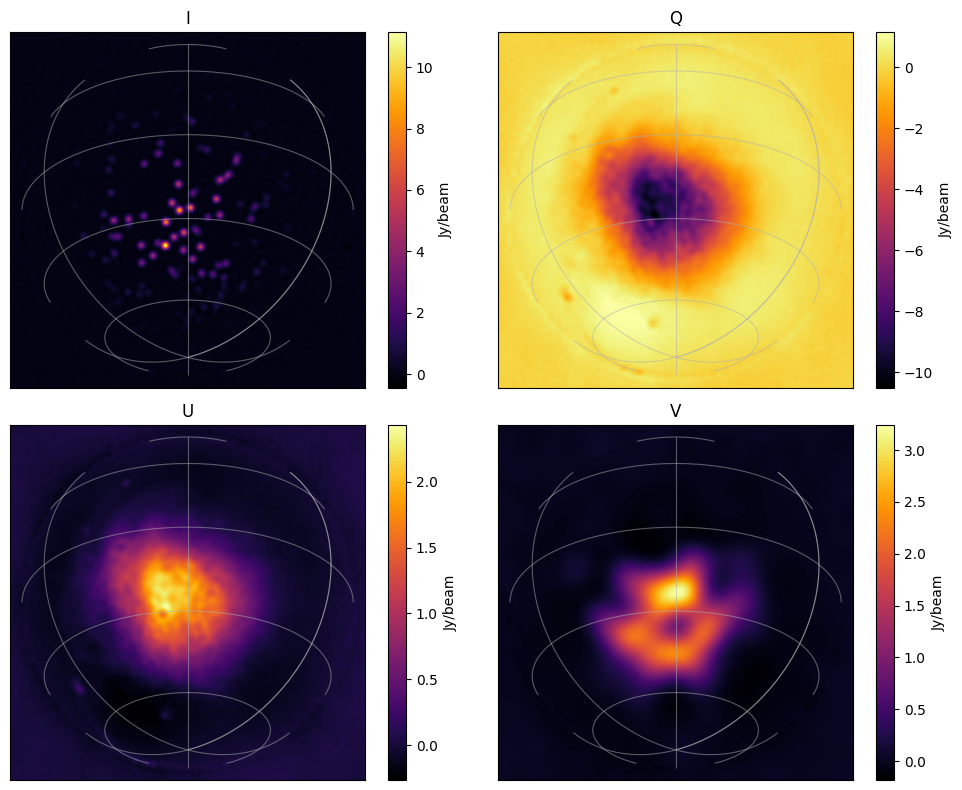

In [12]:
from astropy.wcs import WCS


with fits.open(f'{uvfits_name}-I-image.fits') as hdus:
    w = WCS(hdus[0].header)

fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': w.celestial})


names = ['I', 'Q', 'U', 'V']

files = [f'{uvfits_name}-I-image.fits', f'{uvfits_name}-Q-image.fits',
         f'{uvfits_name}-U-image.fits', f'{uvfits_name}-V-image.fits']

for name, file, ax in zip(names, files, axs.flatten()):
    with fits.open(file) as hdus:
        data = np.squeeze(hdus[0].data)
        
    im = ax.imshow(data, origin='lower', cmap='inferno')
    ax.set_title(name)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.colorbar(im, ax=ax, label='Jy/beam')
    
    ax.grid(alpha=0.5)
    
    
plt.tight_layout()
plt.show()



Great success! We have boring point sources in Stokes I. As we have a constant rotation measure for all directinos, and we've only done a 1.28MHz bandwidth, at these frequencies we get a negative Stokes Q and positive Stokes U; both look like the (low-res) Haslam map. The Stokes V is just a bunch of Gaussian blobs.